In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import random

In [2]:
# go to input dir of stocks and use one txt file for processing

os.chdir('Content/Stocks')

In [3]:
files=os.listdir()
len(files)

7195

In [4]:
data=random.sample([x for x in files if x.endswith('txt') and x.startswith('cms')and os.path.getsize(x)>400000],1)

In [5]:
data

['cms.us.txt']

In [6]:
for i in data:
    df = pd.read_csv(i)

In [7]:
#set date column as index and drop from dataframe
df=df.set_index(df['Date'])
df.drop('Date',axis=1,inplace=True)
df.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1984-12-31,2.1121,2.2303,2.1121,2.2303,1003711,0
1985-01-02,2.2303,2.2303,2.1750,2.2303,126257,0
1985-01-03,2.2303,2.2303,2.1750,2.2303,62047,0
1985-01-04,2.2303,2.2303,2.1750,2.2303,76517,0
1985-01-07,2.1750,2.2303,2.1750,2.1750,96819,0


In [8]:
df.shape

(8280, 6)

In [9]:
window_size=30
train_data=df.iloc[:(7200+window_size), 0:1]
train_data.shape

(7230, 1)

In [10]:
#preprocess data using Minmax sclaer
scaler=preprocessing.MinMaxScaler()
train_data_transform=scaler.fit_transform(np.array(train_data))

In [11]:
x_train,y_train=[],[]
for i in range(len(train_data_transform)-window_size):
    x_train.append(train_data_transform[i:i+window_size])
    y_train.append(train_data_transform[i+window_size])
    

In [12]:
x_train=np.array(x_train)

In [13]:
y_train=np.array(y_train)
y_train.shape

(7200, 1)

In [14]:
model=tf.keras.models.Sequential(
    [tf.keras.layers.LSTM(100,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])),
     tf.keras.layers.Dropout(0.3),
     tf.keras.layers.LSTM(50,return_sequences=True),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.LSTM(50),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(1)
    ])


model.summary()
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [15]:
model.fit(x_train, y_train, epochs=13, batch_size=40)

Epoch 1/13
180/180 [==============================] - 19s 56ms/step - loss: 0.0194 - accuracy: 9.9210e-05
Epoch 2/13
180/180 [==============================] - 10s 57ms/step - loss: 0.0023 - accuracy: 2.0718e-04
Epoch 3/13
180/180 [==============================] - 10s 56ms/step - loss: 0.0019 - accuracy: 1.2751e-05
Epoch 4/13
180/180 [==============================] - 10s 58ms/step - loss: 0.0016 - accuracy: 1.8516e-04
Epoch 5/13
180/180 [==============================] - 11s 59ms/step - loss: 0.0014 - accuracy: 4.2429e-05
Epoch 6/13
180/180 [==============================] - 10s 58ms/step - loss: 0.0013 - accuracy: 1.1754e-04
Epoch 7/13
180/180 [==============================] - 10s 58ms/step - loss: 0.0013 - accuracy: 9.1619e-05
Epoch 8/13
180/180 [==============================] - 10s 58ms/step - loss: 0.0011 - accuracy: 1.5174e-04
Epoch 9/13
180/180 [==============================] - 10s 57ms/step - loss: 0.0011 - accuracy: 1.4725e-04
Epoch 10/13
180/180 [=========================

In [16]:
model.save('stock_model.h5')

In [17]:
train_data = df.iloc[ :int(7200)]
test_data = df.iloc[int(7200): ]
        
        # combining the dataset and taking final test_data shape.
data = pd.concat((train_data['Open'], test_data['Open']), axis=0)
        # len(train_data) - window_size == 7242 - 10 == 7432.
        # Hence, test_set starts from 7432 to take 7243 row as output.
test_input_shape = data[len(train_data) - window_size: ].values
test_input_shape = test_input_shape.reshape(-1,1)
test_input_shape = scaler.transform(test_input_shape) #only transforming the test data.
        
X_test = []
        
for i in range(window_size, len(test_data)+window_size): 
    X_test.append(test_input_shape[i-window_size:i, 0])
            
X_test = np.array(X_test)

In [18]:
X_test.shape

(1080, 30)

In [19]:
 #to make values compatible with lstm
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [26]:
print(X_test)

[[[0.74845352]
  [0.72330924]
  [0.70569442]
  ...
  [0.76606834]
  [0.77525567]
  [0.77902041]]

 [[0.72330924]
  [0.70569442]
  [0.70697236]
  ...
  [0.77525567]
  [0.77902041]
  [0.77511752]]

 [[0.70569442]
  [0.70697236]
  [0.72479441]
  ...
  [0.77902041]
  [0.77511752]
  [0.78468478]]

 ...

 [[1.52827178]
  [1.50937903]
  [1.51728842]
  ...
  [1.58698783]
  [1.59147788]
  [1.58975094]]

 [[1.50937903]
  [1.51728842]
  [1.51932622]
  ...
  [1.59147788]
  [1.58975094]
  [1.6122012 ]]

 [[1.51728842]
  [1.51932622]
  [1.5179792 ]
  ...
  [1.58975094]
  [1.6122012 ]
  [1.61945436]]]


In [20]:
prediction = model.predict(X_test)

prediction_inverse = scaler.inverse_transform(prediction)

In [25]:
print(prediction)

[[0.751262  ]
 [0.75152063]
 [0.7529088 ]
 ...
 [1.4354168 ]
 [1.4391074 ]
 [1.444223  ]]


In [31]:
openn=float(input('open:'))
high=float(input('high:'))
low=float(input('low:'))
close=float(input('close:'))
vol=float(input('Vol:'))
opnint=int(input('OpenINT:'))
l=[openn,high,low,close,vol,opnint]
l=np.array(l)
l = l.reshape(-1,1, 1)
inp=model.predict(l)
inp

open:2.2972
high:2.3178
low:2.2972
close:2.2972
Vol:26437
OpenINT:0


array([[0.36425796],
       [0.36566803],
       [0.36425796],
       [0.36425796],
       [1.1076378 ],
       [0.22715473]], dtype=float32)

In [21]:
prediction_inverse.shape

(1080, 1)

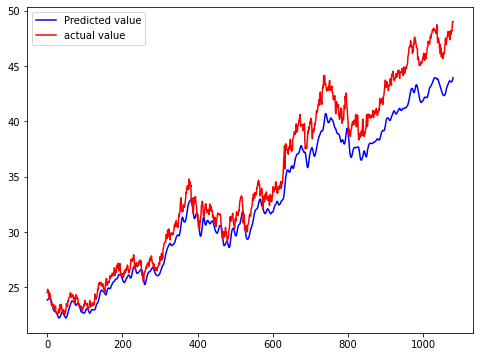

In [22]:
y_test = df.iloc[int(7200): ,0:1].values
plt.figure(figsize=(8,6))
plt.plot(prediction_inverse, color='blue', label='Predicted value')
plt.plot(y_test, color ='red', label='actual value')
plt.legend()
plt.show()

In [23]:
print('Mean Absolute Error: ', mean_absolute_error(y_test, prediction_inverse))
print('Mean Squared Error: ', mean_squared_error(y_test, prediction_inverse))

Mean Absolute Error:  1.8149671508647778
Mean Squared Error:  4.884006461154203
